# This notebook attempts to speed up computations from earlier sensitivity notebook

In [1]:
import numpy as np, time
from typing import Tuple
import math
from scipy.special import erfcinv
from scipy.stats import chi2
from Include.preRun import pre_run
from Include.makeCaTable import make_ca_table
from init_settings import init_settings
from Include.plotAcqSearch import plotAcqSearch

In [2]:
#
#  Read datafile, return a complex numpy vector
#  

def readAcqData(settings, code_periods = None, skip = None, framing = False) -> np.ndarray:
    """
    read a datafile
    settings is the standard settings object.  We will use:
        fileName
        skipNumberOfBytes
        samplingFreq
        codeFreqBasis
        codeLength
        acqNonCohTime
        acqCoherentInt
    code_periods is the number of 1mS code periods we need
    skip is the number of samples in the datafile to skip
    """
    
    try:
        fid = open(settings.fileName, 'rb')
    except Exception as e:
        # Error while opening the data file.
        raise RuntimeError(f"Unable to read file {settings.fileName}: {e}")
    
    # Initialize the multiplier to adjust for the data type
    data_adapt_coeff = 1 if settings.fileType == 1 else 2
    
    # Move the starting point of processing. Can be used to start the
    # signal processing at any point in the data record (e.g. good for long
    # records or for signal processing in blocks).
    if skip == None:
        fid.seek(data_adapt_coeff * settings.skipNumberOfBytes, 0)
    else:
        fid.seek(data_adapt_coeff * skip, 0)
    
    # %% Acquisition ============================================================
    samples_per_code = int(round(settings.codeLength * settings.samplingFreq / settings.codeFreqBasis))
    # At least 42ms of signal are needed for fine frequency estimation

    code_len = (2*settings.acqCoherentInt)*(settings.acqNonCohTime)
    #code_len = max(42, settings.acqNonCohTime + 2)
    
    if code_periods == None:
        num_samples = data_adapt_coeff * code_len * samples_per_code
    else:
        num_samples = code_periods * code_len * samples_per_code
        
    # Read data for acquisition.
    if settings.dataType == 'schar':
        dtype = np.int8
    elif settings.dataType == 'short':
        dtype = np.int16
    elif settings.dataType == 'float':
        dtype = np.float32
    else:
        raise ValueError(f"Unsupported dataType: {settings.dataType}")
    data = np.fromfile(fid, dtype=dtype, count=num_samples)
    if data.size < num_samples:
        raise ValueError('Could not read enough data from the data file.')
    
    if data_adapt_coeff == 2:
        # For complex data, separate I and Q
        data_i = data[::2]
        data_q = data[1::2]
        data = data_i + 1j * data_q
    fid.close()
    # If the framing flag is set to be true, we fill 1mS of data down each column
    # and there is one column for each code period
    #
    if framing == True:
        data = data.reshape(-1, code_len)
    return (data)

In [3]:
settings = init_settings()
print (f'Data File: {settings.fileName}')
longdata = readAcqData(settings, framing = False)

Data File: /mnt/e/gnss_data/L1_IF20KHz_FS18MHz/L1_IF20KHz_FS18MHz.bin


In [4]:
PRN = 1
thisCode = make_ca_table(PRN, settings)
print (thisCode.shape)

(18000,)


In [5]:
from scipy import fft as sfft

In [6]:
def detectCASat (PRN, longData, settings, showStatus=False, nCoherent = None, nNonCoherent = None, pfa = None) -> dict:
    """
    Attempt to detect the CA Code from the satellite with PRN
    Receive a long data record from the file; this will be a single, long vector
    Characteristics of the data and processing are provided in settings
    """
    startTime = time.time()
    if (showStatus==True):
        print ("Beginning Detection of PRN {PRN}")

    tSample = 1 / settings.samplingFreq
    low_freq = -1 * settings.acqSearchBand
    high_freq = settings.acqSearchBand

    if nCoherent == None:
        nCoherent = int(settings.acqCoherentInt)

    if nNonCoherent == None:
        nNonCoherent = int(settings.acqNonCohTime)
    if showStatus == True:
        print (f'Coherent Integrations: {nCoherent}, Non-Coherent Integrations: {nNonCoherent}')
    if pfa == None:
        pfa = 0.05  # This is the Probability of False Alarm for a satellite
    
    #
    # Compute the number of samples in each code, and the number of codes
    # that will be required
    samples_per_code = int(round(settings.codeLength * settings.samplingFreq / settings.codeFreqBasis))
    #print (f'samples per code: {samples_per_code}')
    numCodes = 2*nCoherent*nNonCoherent
    totalSamples = samples_per_code*numCodes
    #
    # Make sure we've got enough data to do the required analysis
    #
    if len(longData) < totalSamples:
        print ('Insufficient Data to perform acquisition')
        print (f'{totalSamples} Samples Needed, received {len(longData)}')
        return {"success": False, "Error Message": 'Insufficient Data'}
        # In principal, we could read the required data from the file rather than exiting
    
    #
    # Remove any residual DC carrier from the input signal
    # This is vital because we will use a chi-squared distribution later
    # Scale so ammplitude so either real or imaginary part has max
    # amplitude of 1.000; longData becomes a vector with abs(signal) <= 1.0
    #
    rl = np.real(longData)
    im = np.imag(longData)
    rl = rl - np.mean(rl)
    im = im - np.mean(im)
    max_sample = np.max(np.concatenate((rl, im)))
    longData = ((0.5 / max_sample) * (rl + (1j * im))).astype(np.complex64)
    #
    # Mix longData down to baseband (nominally zero Hz IF)
    if settings.IF != 0.0:
        phase_points = (np.arange(len(longData)) * 2 * np.pi * tSample * settings.IF).astype(np.complex64)
        loCarrier = np.exp(-1j * phase_points, dtype=np.complex64)
        longData = longData * loCarrier
    #
    # Make a test template for the PRN we're trying to detect
    # Make templates in both the time and frequency domain
    # Compute the frequency bins of the fft
    
    pnCodeSamples = make_ca_table(PRN, settings)
    #print (type(pnCodeSamples), pnCodeSamples.shape)
    #print (f'first several pnChips: {pnCodeSamples[:20]}')
    zero_padding = np.zeros(samples_per_code*nCoherent)
    #print (f'Zero Padding: {type(zero_padding)}, {zero_padding.shape}')
    prnTemplateTD = np.concatenate((np.tile(pnCodeSamples,nCoherent), zero_padding), dtype=np.complex64)
    #print (f'prnTemplateTD: {prnTemplateTD.shape}, {type(prnTemplateTD)}')
    
    #prnTemplateFD = np.conj(np.fft.fft(prnTemplateTD), dtype=np.complex64)
    prnTemplateFD = np.conj(sfft.fft(prnTemplateTD))
    #
    # Determine which frequency bins are in range for possible doppler
    #
    #print (f'prnTemplateFD shape: {prnTemplateFD.shape}')
    freqs = np.fft.fftfreq(len(prnTemplateTD), tSample)
    #print (f'frequency table: {freqs[:16]}')
    freq_mask = (freqs >= low_freq) & (freqs <= high_freq)   # A boolean vector of frequency values in range
    nFreqBins = np.sum(freq_mask)                            # Number of elements that are between lower and upper frequency
    #
    # Since we know the signal is at baseband of zero IF, 
    # we also know that half the frequencies are on either side of zero
    initialShift = int((nFreqBins - 1) / 2)
    #print (f'Initial Shift = {initialShift}, value = {freqs[initialShift]}')
    freq_vals = freqs[freq_mask]                             # The values of the frequencies in bounds
    #freq_idx = np.where(freq_mask)  #The indexes of the values that are in bounds
    #print(f'frequencies: {freq_vals} \n, indices: {freq_idx}')
    #
    # Reformat the data so there is one row vector for each 
    # Coherent Integration period.
    # Each row will have (2*samples_per_code*nCoherent) samples
    # It makes it a little cleaner to analyze
    #
    data = (longData[:totalSamples]).reshape((nNonCoherent,2*samples_per_code*nCoherent))
    #print (data.shape)
    #
    # This is the main loop where we convolve the PRN sequence against the possible 
    # Frequency shifts
    #
    # Rows for doppler frequencies, time steps along columns
    detector = (np.zeros((nFreqBins, samples_per_code*nCoherent*2))).astype(np.float32)
    for nonCohIndex in range (nNonCoherent):
        if showStatus == True:
            print ("Noncoherent Integration {nonCohIndex}")
        #
        cohDetector = np.zeros((nFreqBins, 2*samples_per_code*nCoherent), dtype=np.complex64)
        #print (f'Looping through: {nonCohIndex}, {startCode}')
        cohData = data [nonCohIndex,:]
        thisDataFD = sfft.fft(cohData)   #Vector of signal data, nCoherent codes long
        thisDataFD = np.roll(thisDataFD, initialShift)
        # Loop through frequencies
        this_freq = np.roll(freqs, initialShift)
        for i in range(nFreqBins):
            convolutionFD = thisDataFD * prnTemplateFD
            cohDetector [i,:] = sfft.ifft(convolutionFD)
            thisDataFD = np.roll(thisDataFD, -1)
        detector += (abs(cohDetector) ** 2).astype(np.float32)  #square because for non-coherent integration we're averaging power
    #
    # Last step is to normalize the detector output based on sample rate and 
    # Number of non coherent detections
    detector = ((1/nNonCoherent) * (1 / samples_per_code) * detector).astype(np.float32)
    peak_val = np.max(detector)
    #
    # This is an attempt to estimate the mean under no-signal conditions (H0 condition)
    # Assume signal is present in only a few cells, and most cells are noise.
    # Average across rows - most rows will be noise, and they'll be pretty consistent.  
    # If we take the median of those cells, it should give us a good estimate of median under
    # No-signal conditions.
    row_mean = np.mean(detector, axis = 1)
    meanval = np.median(row_mean)
    sigma_sq = meanval / nCoherent
    # Compute the detection threshold
    #
    # We want pfa to reflect the possibility of an error in the dataset we were given
    # there are len(detector) samples that are mostly noise-like;
    adjpfa = pfa / len(detector)
    gamma = math.sqrt(2) * chi2.isf(adjpfa, 2*nCoherent)
    threshold = sigma_sq * gamma
    
    signalDetected = (peak_val > threshold)
    peakIndexFlat = np.argmax(detector)
    peakIndex = np.unravel_index(peakIndexFlat, detector.shape)
    
    endTime = time.time()
    runtime = endTime - startTime
    return {
        "success":True,
        "signalDetected": signalDetected,
        "detector":detector,
        "maxValue": peak_val,
        "mean": meanval,
        "pfa": pfa,
        "threshold": threshold,
        "index": peakIndex,
        "peakfrequency": freqs[peakIndex[0]],
        "peaksample": peakIndex[1],
        "freqtable": np.roll(freqs, initialShift)[:nFreqBins],
        "runtime": runtime
    }
    

In [7]:
#detectionResults = detectCASat(7, longdata, settings, nCoherent = 1, nNonCoherent = 1)
detectionResults = detectCASat(3, longdata, settings, nCoherent = 5, nNonCoherent = 10, pfa=0.01)
#print (detectionResults)
runtime = detectionResults["runtime"]
print (f'Completed in {runtime} seconds')
max_location = detectionResults["index"]
detectArray = detectionResults["detector"]
sig = detectionResults["signalDetected"]
mean = detectionResults["mean"]
threshold = detectionResults["threshold"]
maxVal = detectionResults["maxValue"]


print (f'Signal Detected: {sig}')
print (f'max_location: {max_location}')
print (f'Maximum Correlation Value: {maxVal}')
print (f'Threshold Value: {threshold}')
print (f'Peak / Threshold: {maxVal / threshold}')
print (f'Mean Value: {mean:.2e}')


Completed in 3.3731420040130615 seconds
Signal Detected: True
max_location: (np.int64(90), np.int64(67268))
Maximum Correlation Value: 4.6790032386779785
Threshold Value: 2.499505767981391
Peak / Threshold: 1.8719713707469283
Mean Value: 2.43e-01


In [8]:
plotAcqSearch(203, settings, detectArray)

PosixPath('/home/joe/cu_gnss/cugnss-python/plots/coarse_acquisition_PRN_203.jpg')

## Now that we've got a function, let's run it against a hard data set

In [9]:

from new_settings import init_settings
newSettings = init_settings()
print (f'Data File: {newSettings.fileName}, Data Rate: {newSettings.samplingFreq}')
indoorData = readAcqData(newSettings, framing = False)
print (f'{indoorData.shape}')

Data File: /mnt/e/gnss_data/GNSSL1testSet-AeroN453-fs8_00-if0_02.bin, Data Rate: 8000000.0
(3200000,)


In [10]:
sv = []
for k in range(32):
    thisResult = detectCASat(k+1, indoorData, newSettings, nCoherent = 10, nNonCoherent = 10, pfa = 0.01)
    detected = thisResult["signalDetected"]
    print (f'Satellite {k+1} Signal Detected: {detected}')
    sv.append(thisResult)

Satellite 1 Signal Detected: False
Satellite 2 Signal Detected: False
Satellite 3 Signal Detected: False
Satellite 4 Signal Detected: False
Satellite 5 Signal Detected: False
Satellite 6 Signal Detected: False
Satellite 7 Signal Detected: False
Satellite 8 Signal Detected: True
Satellite 9 Signal Detected: False
Satellite 10 Signal Detected: False
Satellite 11 Signal Detected: False
Satellite 12 Signal Detected: False
Satellite 13 Signal Detected: False
Satellite 14 Signal Detected: False
Satellite 15 Signal Detected: True
Satellite 16 Signal Detected: False
Satellite 17 Signal Detected: False
Satellite 18 Signal Detected: False
Satellite 19 Signal Detected: False
Satellite 20 Signal Detected: False
Satellite 21 Signal Detected: False
Satellite 22 Signal Detected: False
Satellite 23 Signal Detected: False
Satellite 24 Signal Detected: False
Satellite 25 Signal Detected: False
Satellite 26 Signal Detected: False
Satellite 27 Signal Detected: False
Satellite 28 Signal Detected: False
Sat

Text(0.5, 1.0, 'Signal Strength of Satellites')

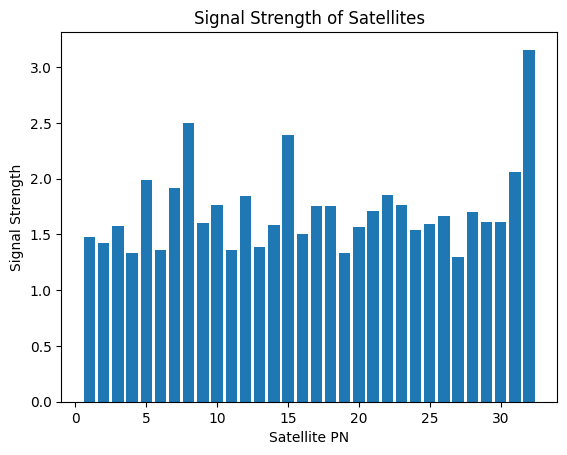

In [28]:
import matplotlib.pyplot as plt
sigStrength = np.zeros(32)
satNum = np.arange(32) + 1
for i in satNum:
    sigStrength[i-1] = sv[i-1]["maxValue"]
plt.bar(satNum, sigStrength)
plt.xlabel("Satellite PN")
plt.ylabel("Signal Strength")
plt.title("Signal Strength of Satellites")

In [31]:
p = 15
detectArray = sv[p-1]["detector"]
plotAcqSearch(300+p, newSettings, detectArray)

PosixPath('/home/joe/cu_gnss/cugnss-python/plots/coarse_acquisition_PRN_315.jpg')

In [ ]:
from scipy.stats import chi2
nCoherent = 5
nNonCoherent = 5
print (detectArray.size)
#variance = np.var(detectArray)
# This is an attempt to estimate the mean under no-signal conditions
# Assume signal is present in only a few cells, and most cells are noise.
# Average across rows - most rows will be noise, and they'll be pretty consistent.  
# If we take the median of those cells, it should give us a good estimate of median under
# No-signal conditions.
row_mean = np.mean(detectArray, axis = 1)
meanval = np.median(row_mean)
sigma_sq = meanval / nCoherent
medianval = np.median(detectArray)
maxval = np.max(detectArray)
pfa = 0.001 * (1/detectArray.size)
gamma = math.sqrt(2) * chi2.isf(pfa, 2*nCoherent)
print (f' max = {maxval}\n mean= {meanval}\n median= {medianval}\n variance= {variance} \n pfa = {pfa} \n gamma = {gamma}')
threshold = (sigma_sq / nNonCoherent) * gamma
print (f'Threshold = {threshold}')

In [ ]:
plotAcqSearch(99, settings, detectArray)

In [ ]:
nCoherent = 5
nNonCoherent = 5
pFA = 0.001

sv23_Results = detectCASat(23, longdata, settings, nCoherent = nCoherent, nNonCoherent = nNonCoherent, pfa=pFA)

detectArray = sv23_Results["detector"]
signalDetected = sv23_Results["signalDetected"]
maxValue = sv23_Results["maxValue"]
threshold = sv23_Results["threshold"]
print (f'Signal Detected = {signalDetected}')
print (f'Max Peak = {maxValue}')
print (f'Threshold Value = {threshold}')
print (f'DetectArray shape = {detectArray.shape}')
#variance = np.var(detectArray)


In [ ]:
# This is an attempt to estimate the mean under no-signal conditions (H0 condition)
# Assume signal is present in only a few cells, and most cells are noise.
# Average across rows - most rows will be noise, and they'll be pretty consistent.  
# If we take the median of those cells, it should give us a good estimate of median under
# No-signal conditions.
row_mean = np.mean(detectArray, axis = 1)
meanval = np.median(row_mean)
sigma_sq = meanval / nCoherent
medianval = np.median(detectArray)
maxval = np.max(detectArray)
#
# We want pfa to reflect the possibility of an error in this measurement
# there are len(detectArray) numbers we're going to evaluate
pfa = 0.05 / len(detectArray)
gamma = math.sqrt(2) * chi2.isf(pfa, 2*nCoherent)
print (f' max = {maxval}\n mean= {meanval}\n sigma square = {sigma_sq}\n  \n pfa = {pfa} \n gamma = {gamma}')
threshold = sigma_sq * gamma
print (f'Threshold = {threshold}')


In [ ]:
freq_list = sv23_Results["freqtable"]
plotAcqSearch(101, settings, detectArray)

In [ ]:
from scipy.stats import chi2
nCoherent = 5
nNonCoherent = 10
pfa = 0.05
sample_variance = mean / nCoherent
erf = chi2.isf(pfa, 2*nCoherent)
print (f'erf = {erf}')

threshold = (gamma / nNonCoherent )* math.sqrt(sample_variance)
print (f'gamma = {gamma}, \nthreshold = {threshold}')

In [ ]:
detected = sv23_Results ["signalDetected"]
mean = sv23_Results["mean"]
variance = sv23_Results["var"]
sdev = math.sqrt(variance)
threshold = sv23_Results["threshold"]
maxVal = sv23_Results["maxValue"]

print (f'Signal Detected: {sig}')
print (f'Peak Value = {maxVal}')
print (f'Signal Threshold: {threshold}')
print (f'Peak / Threshold: {maxVal / threshold}')
print (f'Threshold / sdev: {threshold / sdev}')
print (f'Mean Value: {mean:.2e}, standard deviation: {sdev:.2e}')
print (f'peak / threshold ratio: {maxVal / threshold}')
print (f'(peak - mean) / standard dev: {((maxVal - mean) / sdev)}')

In [ ]:
sv23_matrix = sv23_Results["detector"]
plotAcqSearch(101, settings, sv23_matrix)

In [ ]:
a = np.arange(6)
print(a)
b = a.reshape((2,3))
print (b)

c = np.roll(b,shift=1, axis = 1)
print (c)

In [ ]:
a = np.array([1, 2, 3, 4])
print (a)
b = np.roll(a, 1)
print (b)

In [ ]:
import numpy as np
import scipy.fft as sfft

x32 = np.arange(8, dtype=np.complex64)
x64 = np.arange(8, dtype=np.complex128)

print("NumPy FFT on complex64:", np.fft.fft(x32).dtype)
print("SciPy FFT on complex64:", sfft.fft(x32).dtype)

print("NumPy FFT on complex128:", np.fft.fft(x64).dtype)
print("SciPy FFT on complex128:", sfft.fft(x64).dtype)
